In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import GlobalAveragePooling1D
import yfinance as yf

In [2]:
data = yf.download('BTC-USD', start="2014-09-17", end="2024-05-05")

[*********************100%%**********************]  1 of 1 completed


In [3]:
print(data.head(5))
print("------------------------------------------------------------------")
print(data.shape)
print(type(data))

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  
------------------------------------------------------------------
(3518, 6)
<class 'pandas.core.frame.DataFrame'>


<Axes: title={'center': 'Bitcoin Close stock plot'}, xlabel='Date'>

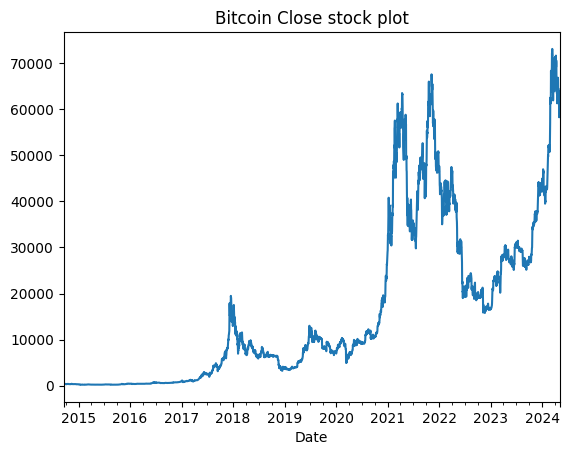

In [4]:
data['Close'].plot(title='Bitcoin Close stock plot')

In [5]:
data[['High', 'Low', 'Close']].values

array([[  468.17401123,   452.42199707,   457.33401489],
       [  456.85998535,   413.10400391,   424.44000244],
       [  427.83499146,   384.53201294,   394.79598999],
       ...,
       [59602.296875  , 56937.203125  , 59123.43359375],
       [63320.50390625, 58848.3125    , 62889.8359375 ],
       [64494.95703125, 62599.3515625 , 63891.47265625]])

In [6]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['High', 'Low', 'Close']].values)

In [7]:
train_size = int(len(data)*0.90)
test_size = len(data)-train_size
print(train_size)
print(test_size)

3166
352


In [8]:
train_data,test_data=data_scaled[0:train_size,:],data_scaled[train_size:len(data_scaled),:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (3166, 3)
test_data:  (352, 3)


In [9]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), :])
        dataY.append(dataset[i + time_step, :])
    return np.array(dataX), np.array(dataY)

In [10]:
time_step = 30
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", x_test.shape)
print("y_test", y_test.shape)

X_train:  (3136, 30, 3)
y_train:  (3136, 3)
X_test:  (322, 30, 3)
y_test (322, 3)


In [11]:
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 3) #sample, time step, features
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 3)
print("X_train: ", x_train.shape)
print("X_test: ", x_test.shape)

X_train:  (3136, 30, 3)
X_test:  (322, 30, 3)


In [12]:
x_train.shape[1]

30

In [33]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(128, activation='gelu', dropout=0.0, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(64, activation='gelu', dropout=0.2))
    #model.add(LSTM(128,
    #                activation="gelu",
    #                recurrent_activation="sigmoid",
    #                use_bias=True,
    #                dropout=0.0,
    #                return_sequences=True,
    #                name="LSTM-1",
    #                input_shape=(x_train.shape[1], x_train.shape[2])))  # Ensure x_train is passed as an argument
    #model.add(LSTM(64,
    #                activation='gelu',
    #                recurrent_activation='sigmoid',
    #                use_bias=True,
    #                dropout=0.2,
    #                return_sequences=True,
    #                name="LSTM-2"))
    #model.add(GlobalAveragePooling1D())
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(3))
    return model

In [34]:
model = create_lstm_model()
model.summary()
model.compile(optimizer='adam',
    loss='mean_squared_error')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 128)           67584     
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 3)                 99        
                                                                 
Total params: 123,331
Trainable params: 123,331
Non-trainable params: 0
_________________________________________________________________


In [35]:
checkpoint_filepath = 'model_{epoch}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_loss',
    mode='min',
    save_best_only=True
)

model_earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 10,
    verbose = 1, #shows message whnen callback takes an action
    mode = 'min',
    restore_best_weights = True
)

history = model.fit(x_train,
    y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=100,
    verbose=1,
    callbacks = [model_checkpoint_callback])

Epoch 1/100
98/98 [==============================] - 12s 74ms/step - loss: 0.0119 - val_loss: 0.0020
Epoch 2/100
98/98 [==============================] - 8s 81ms/step - loss: 7.5290e-04 - val_loss: 0.0015
Epoch 3/100
98/98 [==============================] - 7s 68ms/step - loss: 7.7414e-04 - val_loss: 0.0019
Epoch 4/100
98/98 [==============================] - 8s 82ms/step - loss: 7.7587e-04 - val_loss: 0.0026
Epoch 5/100
98/98 [==============================] - 8s 84ms/step - loss: 7.0318e-04 - val_loss: 0.0011
Epoch 6/100
98/98 [==============================] - 7s 69ms/step - loss: 6.1608e-04 - val_loss: 0.0011
Epoch 7/100
98/98 [==============================] - 8s 81ms/step - loss: 5.8638e-04 - val_loss: 0.0016
Epoch 8/100
98/98 [==============================] - 7s 67ms/step - loss: 4.9601e-04 - val_loss: 0.0018
Epoch 9/100
98/98 [==============================] - 8s 80ms/step - loss: 5.0195e-04 - val_loss: 8.1321e-04
Epoch 10/100
98/98 [==============================] - 7s 70ms/s

In [36]:
training_prediction = model.predict(x_train)
test_prediction = model.predict(x_test)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
training_prediction = scaler.inverse_transform(training_prediction)
test_prediction = scaler.inverse_transform(test_prediction)

11/11 [==============================] - 1s 41ms/step


In [39]:
train_score = np.sqrt(mean_squared_error(y_train, training_prediction))
print(train_score)

865.5335990781199


In [41]:
test_score = np.sqrt(mean_squared_error(y_test, test_prediction))
print(test_score)

1319.8441338604812


In [42]:
#r-2 score
train_r2 = r2_score(training_prediction, y_train)
print(train_r2)
test_r2 = r2_score(test_prediction, y_test)
print(test_r2)

0.9969262789100979
0.9908278410775141


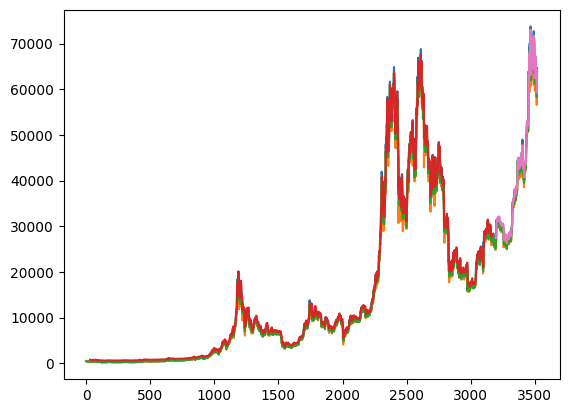

In [43]:
### Plotting
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(training_prediction)+look_back, 0] = training_prediction[:,0]
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(training_prediction)+(look_back*2):len(data_scaled), 0] = test_prediction[:,0]
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [49]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-30,63839.417969,64703.332031,59120.066406,60636.855469,60636.855469,37840840057
2024-05-01,60609.496094,60780.500000,56555.292969,58254.011719,58254.011719,48439780271
2024-05-02,58253.703125,59602.296875,56937.203125,59123.433594,59123.433594,32711813559
2024-05-03,59122.300781,63320.503906,58848.312500,62889.835938,62889.835938,33172023048
2024-05-04,62891.031250,64494.957031,62599.351562,63891.472656,63891.472656,20620477992


In [75]:
input = np.array(x_test[-1:])
pred = model.predict(input)
input = np.append(np.delete(input, 0, axis=1), [pred], axis=1)

future_pred = []

for i in range(0,7):
    pred = model.predict(input)
    input = np.append(np.delete(input, 0, axis=1), [pred], axis=1)
    pred_unscaled = scaler.inverse_transform(pred)
    future_pred.append(pred_unscaled[0])
future_pred = np.array(future_pred)

1/1 [==============================] - 0s 50ms/step


In [76]:
future_pred

array([[62342.67 , 58618.207, 60692.848],
       [61218.438, 57445.977, 59572.37 ],
       [60238.02 , 56460.28 , 58601.43 ],
       [59391.445, 55636.53 , 57768.96 ],
       [58656.48 , 54939.496, 57051.086],
       [58003.977, 54331.223, 56417.32 ],
       [57409.08 , 53781.75 , 55841.82 ]], dtype=float32)

In [79]:
print("High: " + str(int(np.max(future_pred[:,0]))))
print("Low: " + str(int(np.min(future_pred[:,1]))))
print("Average Closing Price: " + str(int(np.mean(future_pred[:,2]))))

High: 62342
Low: 53781
Average Closing Price: 57992
